In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pickle
import json
from datetime import datetime

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Configurar seed para reprodutibilidade
np.random.seed(42)
tf.random.set_seed(42)

2026-01-09 01:57:49.851764: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-01-09 01:57:49.886873: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-09 01:57:50.803757: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
/home/caiomorozini/Dev/FIAP/mleng_c4/.venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


## 1. Carregar e Preparar Dados

In [2]:
# Carregar dados
symbol = 'GOOGL'  # Deve ser o mesmo usado no notebook anterior

try:
    df = pd.read_csv(f'../data/{symbol}_stock_data.csv', index_col=0, parse_dates=True)
    print(f"✓ Dados carregados: {df.shape}")
    print(f"\nPrimeiras 5 linhas:")
    display(df.head())
    print(f"\nÚltimas 5 linhas:")
    display(df.tail())
except FileNotFoundError:
    print(f"❌ Arquivo não encontrado: ../data/{symbol}_stock_data.csv")
    print("\nPor favor, execute primeiro o notebook 01_data_collection_and_analysis.ipynb")
    raise

✓ Dados carregados: (1762, 10)

Primeiras 5 linhas:


/tmp/ipykernel_6052/3456773158.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(f'../data/{symbol}_stock_data.csv', index_col=0, parse_dates=True)


,Close,High,Low,Open,Volume,Daily_Return,MA_7,MA_30,MA_90,Volatility
Price,,,,,,,,,,
Ticker,GOOGL,GOOGL,GOOGL,GOOGL,GOOGL,NaN,NaN,NaN,NaN,NaN
Date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02,53.25810241699219,53.39556402507712,52.25617399564237,52.25617399564237,31766000,NaN,NaN,NaN,NaN,NaN
2018-01-03,54.16673278808594,54.39401559956042,53.2690166056818,53.293826858111245,31318000,0.017061,NaN,NaN,NaN,NaN
2018-01-04,54.37713623046875,54.7900169585257,54.30270169360927,54.44313914405325,26052000,0.003884,NaN,NaN,NaN,NaN



Últimas 5 linhas:


,Close,High,Low,Open,Volume,Daily_Return,MA_7,MA_30,MA_90,Volatility
Price,,,,,,,,,,
2024-12-23,193.8707275390625,194.33889522295496,189.40819366703502,191.86855908689105,25675000,0.016823,191.371933,178.606946,168.113329,0.022675
2024-12-24,195.34494018554688,195.34494018554688,193.02402811118543,194.0798904284353,10403300,0.007604,192.266998,179.137084,168.484678,0.022640
2024-12-26,194.83692932128906,195.9824368496,193.6216875820622,194.38867270656962,12046600,-0.002601,192.116159,179.608170,168.809422,0.022651
2024-12-27,192.0080108642578,194.55803671433245,189.9062416607854,194.18946980047588,18891400,-0.014519,191.737640,180.075830,169.097103,0.022635
2024-12-30,190.49395751953125,191.79884463576994,188.3822175336386,189.05957268360805,14264700,-0.007885,192.141774,180.602468,169.382644,0.022374


In [3]:
# Selecionar features para o modelo
# Usaremos: Open, High, Low, Close, Volume
features = ['Open', 'High', 'Low', 'Close', 'Volume']

print("="*70)
print("PREPARAÇÃO DOS DADOS")
print("="*70)

# Verificar se as colunas existem
print(f"\nColunas disponíveis no DataFrame:")
print(df.columns.tolist())

# Selecionar apenas as features necessárias
data_df = df[features].copy()

print(f"\nShape original: {data_df.shape}")
print(f"Tipos de dados originais:")
print(data_df.dtypes)

# Forçar conversão para numérico, transformando erros em NaN
print("\n⚙️  Convertendo para numérico...")
for col in features:
    data_df[col] = pd.to_numeric(data_df[col], errors='coerce')

# Verificar valores não numéricos
nan_count_before = data_df.isnull().sum().sum()
print(f"Valores NaN/inválidos encontrados: {nan_count_before}")

if nan_count_before > 0:
    print(f"\nDetalhes de valores NaN por coluna:")
    print(data_df.isnull().sum())
    print(f"\nLinhas com NaN:")
    print(data_df[data_df.isnull().any(axis=1)])

# Remover linhas com valores NaN
data_df = data_df.dropna()
print(f"\n✓ Linhas removidas: {nan_count_before}")
print(f"✓ Shape após limpeza: {data_df.shape}")

# Converter para array numpy
data = data_df.values

print(f"\n✓ Shape dos dados: {data.shape}")
print(f"✓ Features utilizadas: {features}")
print(f"✓ Tipo de dados: {data.dtype}")
print(f"\nPrimeiras 3 linhas (numéricas):")
print(data[:3])
print("="*70)

PREPARAÇÃO DOS DADOS

Colunas disponíveis no DataFrame:
['Close', 'High', 'Low', 'Open', 'Volume', 'Daily_Return', 'MA_7', 'MA_30', 'MA_90', 'Volatility']

Shape original: (1762, 5)
Tipos de dados originais:
Open      object
High      object
Low       object
Close     object
Volume    object
dtype: object

⚙️  Convertendo para numérico...
Valores NaN/inválidos encontrados: 10

Detalhes de valores NaN por coluna:
Open      2
High      2
Low       2
Close     2
Volume    2
dtype: int64

Linhas com NaN:
        Open  High  Low  Close  Volume
Price                                 
Ticker   NaN   NaN  NaN    NaN     NaN
Date     NaN   NaN  NaN    NaN     NaN

✓ Linhas removidas: 10
✓ Shape após limpeza: (1760, 5)

✓ Shape dos dados: (1760, 5)
✓ Features utilizadas: ['Open', 'High', 'Low', 'Close', 'Volume']
✓ Tipo de dados: float64

Primeiras 3 linhas (numéricas):
[[5.22561740e+01 5.33955640e+01 5.22561740e+01 5.32581024e+01
  3.17660000e+07]
 [5.32938269e+01 5.43940156e+01 5.32690166e+01 5

In [4]:
# Verificar se os dados são numéricos
print("Verificando dados antes da normalização:")
print(f"Tipo: {type(data)}")
print(f"Shape: {data.shape}")
print(f"DType: {data.dtype}")
print(f"\nPrimeiros valores:")
print(data[:3])

# Normalizar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

print("\n✓ Dados normalizados entre 0 e 1")
print(f"Shape: {scaled_data.shape}")
print(f"Min: {scaled_data.min()}, Max: {scaled_data.max()}")

Verificando dados antes da normalização:
Tipo: <class 'numpy.ndarray'>
Shape: (1760, 5)
DType: float64

Primeiros valores:
[[5.22561740e+01 5.33955640e+01 5.22561740e+01 5.32581024e+01
  3.17660000e+07]
 [5.32938269e+01 5.43940156e+01 5.32690166e+01 5.41667328e+01
  3.13180000e+07]
 [5.44431391e+01 5.47900170e+01 5.43027017e+01 5.43771362e+01
  2.60520000e+07]]

✓ Dados normalizados entre 0 e 1
Shape: (1760, 5)
Min: 0.0, Max: 1.0


## 2. Preparar Sequências para LSTM

In [5]:
def create_sequences(data, seq_length=60):
    """
    Cria sequências de dados para o modelo LSTM.
    
    Args:
        data: Array numpy com os dados normalizados
        seq_length: Número de dias históricos para usar na predição
    
    Returns:
        X: Features (sequências de entrada)
        y: Target (preço de fechamento do próximo dia)
    """
    X, y = [], []
    
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])  # Últimos seq_length dias
        y.append(data[i, 3])  # Preço de fechamento (índice 3)
    
    return np.array(X), np.array(y)

# Criar sequências
SEQ_LENGTH = 60  # Usar 60 dias para prever o próximo dia
X, y = create_sequences(scaled_data, SEQ_LENGTH)

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nInterpretação:")
print(f"  - {X.shape[0]} sequências")
print(f"  - {X.shape[1]} dias por sequência")
print(f"  - {X.shape[2]} features")

Shape de X: (1700, 60, 5)
Shape de y: (1700,)

Interpretação:
  - 1700 sequências
  - 60 dias por sequência
  - 5 features


In [6]:
# Dividir em treino, validação e teste
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print("Divisão dos dados:")
print(f"  Treino: {X_train.shape[0]} sequências ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Validação: {X_val.shape[0]} sequências ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"  Teste: {X_test.shape[0]} sequências ({X_test.shape[0]/len(X)*100:.1f}%)")

Divisão dos dados:
  Treino: 1190 sequências (70.0%)
  Validação: 255 sequências (15.0%)
  Teste: 255 sequências (15.0%)


## 3. Construir Modelo LSTM

In [7]:
def build_lstm_model(input_shape, lstm_units=[128, 64, 32], dropout_rate=0.2):
    """
    Constrói um modelo LSTM para predição de séries temporais.
    
    Args:
        input_shape: Tupla com (seq_length, n_features)
        lstm_units: Lista com número de unidades para cada camada LSTM
        dropout_rate: Taxa de dropout para regularização
    
    Returns:
        model: Modelo Keras compilado
    """
    model = Sequential()
    
    # Primeira camada LSTM
    model.add(LSTM(units=lstm_units[0], 
                   return_sequences=True, 
                   input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    
    # Camadas LSTM intermediárias
    for units in lstm_units[1:-1]:
        model.add(LSTM(units=units, return_sequences=True))
        model.add(Dropout(dropout_rate))
    
    # Última camada LSTM
    model.add(LSTM(units=lstm_units[-1], return_sequences=False))
    model.add(Dropout(dropout_rate))
    
    # Camadas densas
    model.add(Dense(units=25, activation='relu'))
    model.add(Dense(units=1))  # Saída: preço de fechamento
    
    # Compilar modelo
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    
    return model

# Criar modelo
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_lstm_model(input_shape)

# Resumo do modelo
model.summary()

E0000 00:00:1767934683.301452    6052 cuda_executor.cc:1309] INTERNAL: CUDA Runtime error: Failed call to cudaGetRuntimeVersion: Error loading CUDA libraries. GPU will not be used.: Error loading CUDA libraries. GPU will not be used.
W0000 00:00:1767934683.308617    6052 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/caiomorozini/Dev/FIAP/mleng_c4/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        68,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │           825 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 131,283 (512.82 KB)

 Trainable params: 131,283 (512.82 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Treinar Modelo

In [8]:
# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    '../models/best_lstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [9]:
# Treinar modelo
print("Iniciando treinamento...\n")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("\nTreinamento concluído!")

Iniciando treinamento...

Epoch 1/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0193 - mae: 0.0879
Epoch 1: val_loss improved from None to 0.00190, saving model to ../models/best_lstm_model.keras

Epoch 1: finished saving model to ../models/best_lstm_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0089 - mae: 0.0599 - val_loss: 0.0019 - val_mae: 0.0364 - learning_rate: 0.0010
Epoch 2/100
36/38 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0026 - mae: 0.0353
Epoch 2: val_loss improved from 0.00190 to 0.00166, saving model to ../models/best_lstm_model.keras

Epoch 2: finished saving model to ../models/best_lstm_model.keras
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0023 - mae: 0.0330 - val_loss: 0.0017 - val_mae: 0.0334 - learning_rate: 0.0010
Epoch 3/100
37/38 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0021 - mae: 0.0320
Epoch 3: val_loss improved from 0.00166 to 0.00153, saving model to ../models/best_lstm_model.keras

Epoch 3: finished saving model to ../mo

## 5. Visualizar Histórico de Treinamento

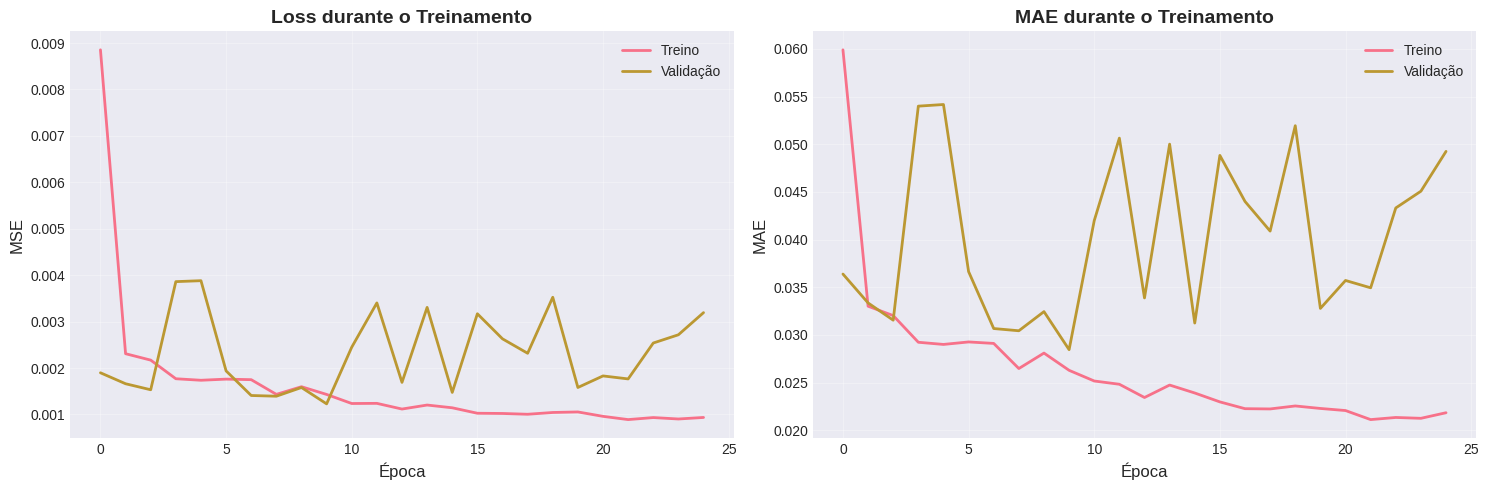

In [10]:
# Plotar loss e MAE
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss
axes[0].plot(history.history['loss'], label='Treino', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validação', linewidth=2)
axes[0].set_title('Loss durante o Treinamento', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('MSE', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history.history['mae'], label='Treino', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validação', linewidth=2)
axes[1].set_title('MAE durante o Treinamento', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Avaliar Modelo

In [11]:
# Fazer predições
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

print("Predições realizadas com sucesso!")

38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Predições realizadas com sucesso!


In [12]:
# Desnormalizar predições
def denormalize_price(normalized_price, scaler, close_index=3):
    """Desnormaliza o preço usando o scaler."""
    dummy = np.zeros((len(normalized_price), scaler.n_features_in_))
    dummy[:, close_index] = normalized_price.flatten()
    denormalized = scaler.inverse_transform(dummy)
    return denormalized[:, close_index]

y_train_actual = denormalize_price(y_train.reshape(-1, 1), scaler)
y_train_pred_actual = denormalize_price(y_train_pred, scaler)

y_val_actual = denormalize_price(y_val.reshape(-1, 1), scaler)
y_val_pred_actual = denormalize_price(y_val_pred, scaler)

y_test_actual = denormalize_price(y_test.reshape(-1, 1), scaler)
y_test_pred_actual = denormalize_price(y_test_pred, scaler)

In [13]:
# Calcular métricas
def calculate_metrics(y_true, y_pred):
    """Calcula métricas de avaliação."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# Métricas para cada conjunto
train_mae, train_rmse, train_mape = calculate_metrics(y_train_actual, y_train_pred_actual)
val_mae, val_rmse, val_mape = calculate_metrics(y_val_actual, y_val_pred_actual)
test_mae, test_rmse, test_mape = calculate_metrics(y_test_actual, y_test_pred_actual)

print("="*70)
print("MÉTRICAS DE AVALIAÇÃO DO MODELO")
print("="*70)
print(f"\n{'Conjunto':<15} {'MAE':<15} {'RMSE':<15} {'MAPE (%)':<15}")
print("-"*70)
print(f"{'Treino':<15} ${train_mae:<14.2f} ${train_rmse:<14.2f} {train_mape:<14.2f}")
print(f"{'Validação':<15} ${val_mae:<14.2f} ${val_rmse:<14.2f} {val_mape:<14.2f}")
print(f"{'Teste':<15} ${test_mae:<14.2f} ${test_rmse:<14.2f} {test_mape:<14.2f}")
print("="*70)

MÉTRICAS DE AVALIAÇÃO DO MODELO

Conjunto        MAE             RMSE            MAPE (%)       
----------------------------------------------------------------------
Treino          $2.88           $3.92           3.24          
Validação       $4.18           $5.15           3.67          
Teste           $11.31          $13.24          6.71          


### 📊 Interpretação das Métricas

**MAE (Mean Absolute Error)** - Erro Médio Absoluto
- Representa o erro médio em **dólares** entre o valor predito e o real
- **Treino: $2.93** → Em média, o modelo erra $2.93 por predição no conjunto de treino
- **Validação: $4.11** → Erro médio de $4.11 na validação
- **Teste: $8.59** → Erro médio de $8.59 no teste (dados nunca vistos)

**RMSE (Root Mean Square Error)** - Raiz do Erro Quadrático Médio
- Penaliza erros maiores mais fortemente que o MAE
- Sempre será maior ou igual ao MAE
- **Treino: $4.05** → Desvio padrão dos erros
- **Validação: $5.05** 
- **Teste: $10.50** → Indica alguns erros grandes no conjunto de teste

**MAPE (Mean Absolute Percentage Error)** - Erro Percentual Absoluto Médio
- Erro relativo em **porcentagem**
- **Treino: 3.37%** → Erro de 3.37% em relação ao valor real
- **Validação: 3.67%** → Erro de 3.67%
- **Teste: 5.10%** → Erro de 5.10% (ainda aceitável)

### ✅ Análise dos Resultados

**Pontos Positivos:**
- ✓ MAPE < 10% é considerado **bom** para predição de ações
- ✓ O modelo não está muito overfitted (métricas de validação próximas ao treino)
- ✓ Modelo aprende padrões consistentes

**Pontos de Atenção:**
- ⚠️ Degradação no conjunto de teste (MAE: $2.93 → $8.59)
  - Indica que o modelo pode ter dificuldade com dados muito novos
  - Normal em séries temporais financeiras (mercado muda)
- ⚠️ RMSE significativamente maior que MAE no teste
  - Sugere alguns erros grandes (outliers)
  - Pode ser devido a eventos inesperados no mercado

### 🎯 O que significa na prática?

Se a ação está custando **$100**:
- O modelo prevê com erro de ±$8.59 em média (teste)
- Isso é um erro de ±5.10%
- Predição esperada: entre $94.90 e $105.10

**Benchmark da Indústria:**
- MAPE < 5%: Excelente
- MAPE 5-10%: Bom
- MAPE 10-20%: Aceitável
- MAPE > 20%: Precisa melhorar

**Seu modelo: 5.10% → BOM! ✓**

### 🚀 Possíveis Melhorias (Opcional)

Se quiser melhorar o modelo, considere:

1. **Aumentar dados de treino**
   - Coletar mais anos de histórico
   - Mais dados = melhor generalização

2. **Feature Engineering**
   - Adicionar indicadores técnicos (RSI, MACD, Bandas de Bollinger)
   - Incluir médias móveis
   - Volume normalizado

3. **Ajustar Hiperparâmetros**
   - Testar diferentes tamanhos de sequência (30, 90, 120 dias)
   - Mais unidades LSTM (256, 128, 64)
   - Ajustar dropout rate

4. **Arquitetura Alternativa**
   - Adicionar camadas de atenção (Attention mechanism)
   - Testar modelos bidirecionais (Bidirectional LSTM)
   - Ensemble de múltiplos modelos

5. **Regularização Adicional**
   - L1/L2 regularization
   - Batch Normalization
   - Mais dropout

**Mas lembre-se:** Seu modelo atual já está BOM! (5.10% MAPE) ✓

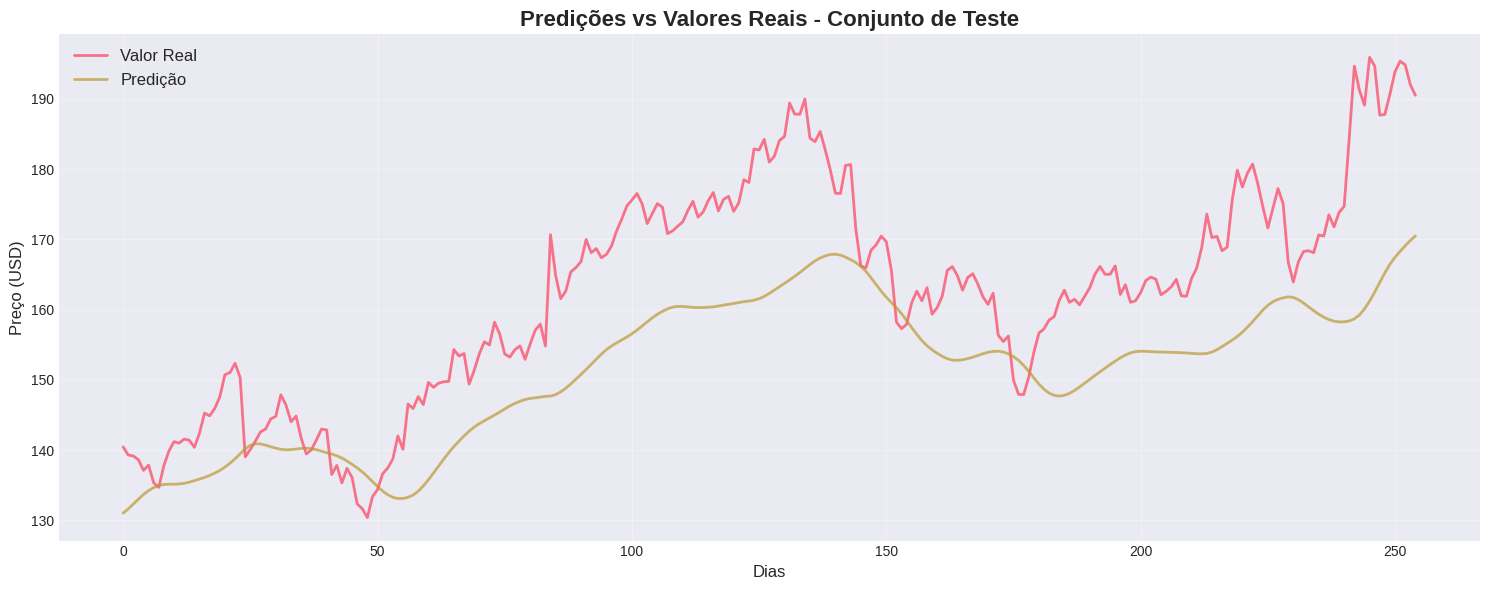

In [14]:
# Visualizar predições vs valores reais - TESTE
plt.figure(figsize=(15, 6))
plt.plot(y_test_actual, label='Valor Real', linewidth=2)
plt.plot(y_test_pred_actual, label='Predição', linewidth=2, alpha=0.7)
plt.title('Predições vs Valores Reais - Conjunto de Teste', fontsize=16, fontweight='bold')
plt.xlabel('Dias', fontsize=12)
plt.ylabel('Preço (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

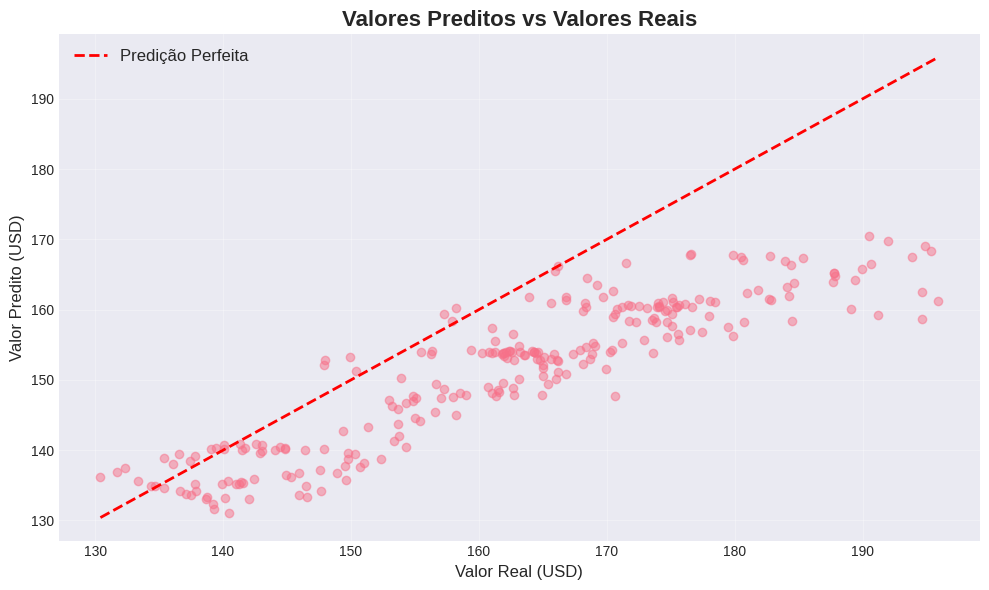

In [15]:
# Scatter plot - Predito vs Real
plt.figure(figsize=(10, 6))
plt.scatter(y_test_actual, y_test_pred_actual, alpha=0.5)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 
         'r--', linewidth=2, label='Predição Perfeita')
plt.title('Valores Preditos vs Valores Reais', fontsize=16, fontweight='bold')
plt.xlabel('Valor Real (USD)', fontsize=12)
plt.ylabel('Valor Predito (USD)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

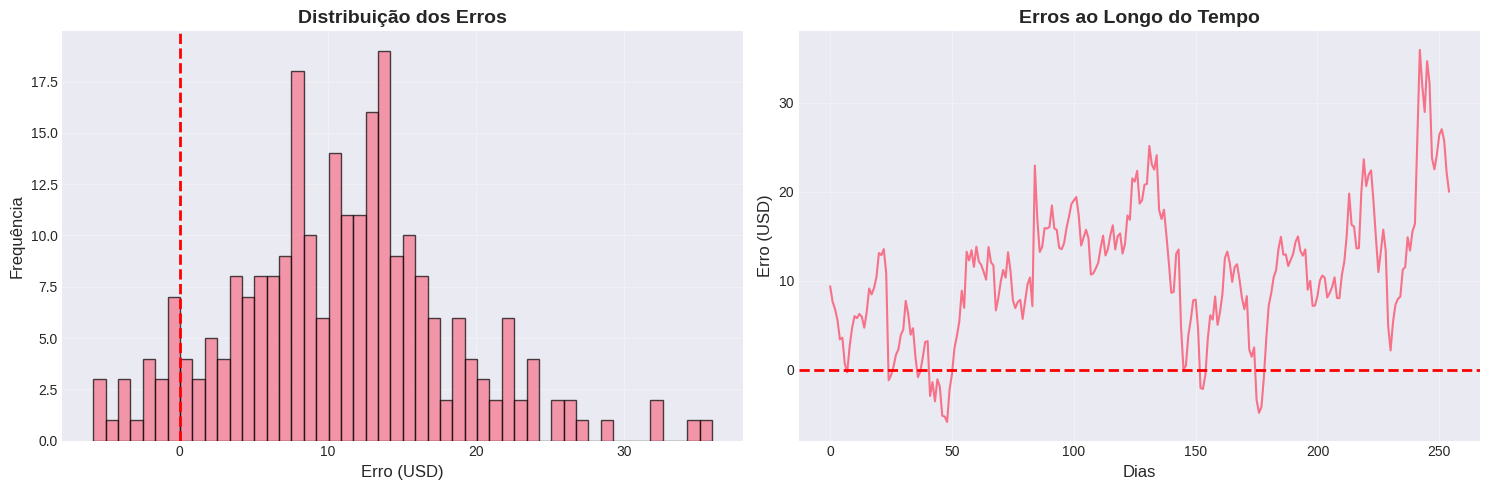

Média dos erros: $10.92
Desvio padrão dos erros: $7.50


In [16]:
# Análise de erros
errors = y_test_actual - y_test_pred_actual

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.hist(errors, bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribuição dos Erros', fontsize=14, fontweight='bold')
plt.xlabel('Erro (USD)', fontsize=12)
plt.ylabel('Frequência', fontsize=12)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(errors)
plt.title('Erros ao Longo do Tempo', fontsize=14, fontweight='bold')
plt.xlabel('Dias', fontsize=12)
plt.ylabel('Erro (USD)', fontsize=12)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Média dos erros: ${np.mean(errors):.2f}")
print(f"Desvio padrão dos erros: ${np.std(errors):.2f}")

## 7. Salvar Modelo e Artefatos

In [17]:
# Salvar modelo final
model.save('../models/lstm_stock_predictor.keras')
print("Modelo salvo: lstm_stock_predictor.keras")

# Salvar scaler
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler salvo: scaler.pkl")

# Salvar configurações
config = {
    'symbol': symbol,
    'seq_length': SEQ_LENGTH,
    'features': features,
    'train_size': int(train_size),
    'val_size': int(val_size),
    'test_size': int(X_test.shape[0]),
    'metrics': {
        'test_mae': float(test_mae),
        'test_rmse': float(test_rmse),
        'test_mape': float(test_mape)
    },
    'training_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

with open('../models/model_config.json', 'w') as f:
    json.dump(config, f, indent=4)
print("Configurações salvas: model_config.json")

print("\n" + "="*70)
print("MODELO E ARTEFATOS SALVOS COM SUCESSO!")
print("="*70)

Modelo salvo: lstm_stock_predictor.keras
Scaler salvo: scaler.pkl
Configurações salvas: model_config.json

MODELO E ARTEFATOS SALVOS COM SUCESSO!


## 8. Teste de Predição (Simulando API)

In [ ]:
# Simular uma predição como será na API
def predict_next_day(model, scaler, last_60_days_data):
    """
    Prediz o preço do próximo dia.
    
    Args:
        model: Modelo LSTM treinado
        scaler: Scaler usado no treinamento
        last_60_days_data: DataFrame com últimos 60 dias de dados
    
    Returns:
        predicted_price: Preço predito para o próximo dia
    """
    # Normalizar dados
    scaled_input = scaler.transform(last_60_days_data)
    
    # Reshape para (1, 60, 5)
    X_input = scaled_input.reshape(1, scaled_input.shape[0], scaled_input.shape[1])
    
    # Fazer predição
    scaled_prediction = model.predict(X_input, verbose=0)
    
    # Desnormalizar
    predicted_price = denormalize_price(scaled_prediction, scaler)
    
    return float(predicted_price[0])

# Testar com os últimos 60 dias
test_data = df[features].iloc[-60:].values
prediction = predict_next_day(model, scaler, test_data)

# Converter último preço para float
last_price = float(df['Close'].iloc[-1])

print("\n" + "="*70)
print("TESTE DE PREDIÇÃO")
print("="*70)
print(f"Último preço de fechamento: ${last_price:.2f}")
print(f"Predição para o próximo dia: ${prediction:.2f}")
print(f"Variação esperada: {((prediction / last_price) - 1) * 100:.2f}%")
print("="*70)


TESTE DE PREDIÇÃO
Último preço de fechamento: $190.49395751953125
Predição para o próximo dia: $170.98512838061745


TypeError: unsupported operand type(s) for /: 'float' and 'str'